In [1]:
%load_ext autoreload
%autoreload 2

# Bank Term Deposit Subscription Prediction

In [10]:
import numpy as np
import polars as pl

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

# Load Train Dataset

In [11]:
train_data = pl.read_csv('../../data/playground-series-s5e8/train.csv')
train_data.head(2)

id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
i64,i64,str,str,str,str,i64,str,str,str,i64,str,i64,i64,i64,i64,str,i64
0,42,"""technician""","""married""","""secondary""","""no""",7,"""no""","""no""","""cellular""",25,"""aug""",117,3,-1,0,"""unknown""",0
1,38,"""blue-collar""","""married""","""secondary""","""no""",514,"""no""","""no""","""unknown""",18,"""jun""",185,1,-1,0,"""unknown""",0


# Inspect

In [12]:
train_data.shape

(750000, 18)

In [15]:
train_data.glimpse(max_items_per_column=2)

Rows: 750000
Columns: 18
$ id        <i64> 0, 1
$ age       <i64> 42, 38
$ job       <str> 'technician', 'blue-collar'
$ marital   <str> 'married', 'married'
$ education <str> 'secondary', 'secondary'
$ default   <str> 'no', 'no'
$ balance   <i64> 7, 514
$ housing   <str> 'no', 'no'
$ loan      <str> 'no', 'no'
$ contact   <str> 'cellular', 'unknown'
$ day       <i64> 25, 18
$ month     <str> 'aug', 'jun'
$ duration  <i64> 117, 185
$ campaign  <i64> 3, 1
$ pdays     <i64> -1, -1
$ previous  <i64> 0, 0
$ poutcome  <str> 'unknown', 'unknown'
$ y         <i64> 0, 0



In [18]:
train_data.schema

Schema([('id', Int64),
        ('age', Int64),
        ('job', String),
        ('marital', String),
        ('education', String),
        ('default', String),
        ('balance', Int64),
        ('housing', String),
        ('loan', String),
        ('contact', String),
        ('day', Int64),
        ('month', String),
        ('duration', Int64),
        ('campaign', Int64),
        ('pdays', Int64),
        ('previous', Int64),
        ('poutcome', String),
        ('y', Int64)])

# Target Distribution

<Axes: xlabel='y', ylabel='count'>

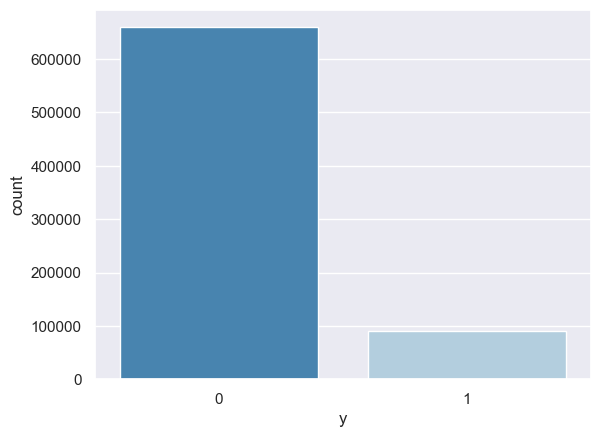

In [8]:
sns.countplot(data=train_data, x='y', palette = 'Blues_r')

# Drop Unnecessary Columns

In [20]:
columns_to_drop = ['id', 'day', 'month', 'contact']

train_data = train_data.drop(columns_to_drop)
train_data.glimpse(max_items_per_column=2)

Rows: 750000
Columns: 14
$ age       <i64> 42, 38
$ job       <str> 'technician', 'blue-collar'
$ marital   <str> 'married', 'married'
$ education <str> 'secondary', 'secondary'
$ default   <str> 'no', 'no'
$ balance   <i64> 7, 514
$ housing   <str> 'no', 'no'
$ loan      <str> 'no', 'no'
$ duration  <i64> 117, 185
$ campaign  <i64> 3, 1
$ pdays     <i64> -1, -1
$ previous  <i64> 0, 0
$ poutcome  <str> 'unknown', 'unknown'
$ y         <i64> 0, 0



# Convert to Category

In [22]:
cat_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome', 'y'
]

train_data = train_data.with_columns([
    pl.col(c).cast(pl.Categorical) for c in cat_cols
])

train_data.glimpse(max_items_per_column=2)

Rows: 750000
Columns: 14
$ age       <i64> 42, 38
$ job       <cat> technician, blue-collar
$ marital   <cat> married, married
$ education <cat> secondary, secondary
$ default   <cat> no, no
$ balance   <i64> 7, 514
$ housing   <cat> no, no
$ loan      <cat> no, no
$ duration  <i64> 117, 185
$ campaign  <i64> 3, 1
$ pdays     <i64> -1, -1
$ previous  <i64> 0, 0
$ poutcome  <cat> unknown, unknown
$ y         <cat> technician, technician



In [31]:
train_data.head(2)

age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,poutcome,y
i64,cat,cat,cat,cat,i64,cat,cat,i64,i64,i64,i64,cat,cat
42,"""technician""","""married""","""secondary""","""no""",7,"""no""","""no""",117,3,-1,0,"""unknown""","""technician"""
38,"""blue-collar""","""married""","""secondary""","""no""",514,"""no""","""no""",185,1,-1,0,"""unknown""","""technician"""


# Missing Values

In [28]:
train_data.null_count()

age,job,marital,education,default,balance,housing,loan,duration,campaign,pdays,previous,poutcome,y
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
train_data.width

14